Ноздрова В. ИУ5-81Б

# Задание 1

In [ ]:
Variant<-15
set.seed(Variant)
k<-sample(c(10:25),1)
m<-sample(c(3:6),1)
t1<-sample(c(14:20),1)
t2<-sample(c(2:5),1)
View(data.frame(k,m,t1,t2))

k,m,t1,t2
<int>,<int>,<int>,<int>
14,5,15,3




---



Граф состояний:

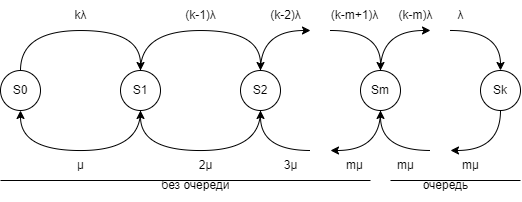

In [ ]:
t1 = 800
t2 = 8
k = 100
m = 1

In [ ]:
lambda = 1/t1
mu = 1/t2

In [ ]:
y = lambda/mu

Обозначим $y = \frac{\lambda}{\mu}$

Система замкнутая многоканальная, поэтому:

$$ P_0=\left(1+\frac{ky}{1!}+\frac{k(k-1)y^2}{2!}+\ldots+\frac{k(k-1)\cdot ... \cdot (k-m+1)y^m}{m!}+\frac{k(k-1)\cdot ... \cdot (k-m)y^m\cdot y}{m!m}+\ldots + \frac{k!y^k}{m!m^{k-m}}\right)^{-1} $$

$$P_0=\left(\sum_{i=0}^m\frac{k!y^i}{(k-i)!i!}+\sum_{i=m+1}^k\frac{k!y^i}{(k-i)!m!m^{i-m}}\right)^{-1}$$

$$ P_1=\frac{ky}{1!}\cdot P_0, P_2=\frac{k(k-1)y^2}{2!}\cdot P_0, \ldots, P_m=\frac{k!y^m}{(k-m)!m!}\cdot P_0 $$

$$P_{m+1}=\frac{k!y^{m+1}}{m\cdot m! (k-m-1)!}\cdot P_0, \ldots, P_{m+r}=\frac{k!y^{m+r}}{m^r\cdot m! (k-m-r)!}\cdot P_0$$



In [ ]:
row1 <- function(start,stop)
{
  s <- c()
  for (i in start:stop)
  {
    s <- c(s, factorial(k)*y^i/(factorial(k-i)*factorial(i)))
  }
  return(s)
}

row2 <- function(start,stop)
{
  s <- c()
  for (i in start:stop)
  {
    s <- c(s, factorial(k)*y^i/(factorial(k-i)*factorial(m)*m^(i-m)))
  }
  return(s)
}

In [ ]:
P_0 <- (sum(row1(0,m))+sum(row2((m+1),k)))^(-1)
P_0

[1] 0.07570045

Вероятность того, что заявка не будет выполнена сразу же, то есть все сервера заняты и, возможно, есть очередь:

$$ P_{отлож} = \sum_{i=m}^k P_i = P_0 \cdot \frac{k!y^m}{(k-m)!m!} +P_0 \cdot \sum_{i=m+1}^k \frac{k!y^i}{(k-i)!m!m^{i-m}}$$

In [ ]:
P_otlozh = P_0*k*y^m/(factorial(k-m)*factorial(m)) + P_0*sum(row2(m+1, k))
P_otlozh

[1] 0.02562595

Cреднее время до получения пользователем результатов реализации:

$$ T_{сист} = \frac{L_{сист}}{\Lambda} $$

$$ L_{сист} = \sum_{i=1}^k P_i \cdot i = P_0 \cdot \left( \sum_{i=1}^m\frac{k!y^i}{(k-i)!i!} \cdot i +\sum_{i=m+1}^k\frac{k!y^i}{(k-i)!m!m^{i-m}} \cdot i \right)$$

$$ \Lambda = (k-L_{сист})\cdot \lambda $$


In [ ]:
L_sist = P_0 * (sum(row1(1,m)*c(1:m)) + sum(row2(m+1,k)*c((m+1):k)))
L_sist

[1] 2.363385

In [ ]:
L = (k-L_sist)*lambda
L

[1] 0.7757743

In [ ]:
T_sist = L_sist/L
T_sist

[1] 3.046486

Cреднее количество программ, ожидающих выполнения на сервере:

$$L_{оч}  = \sum_{i=1}^{k-m} P_{m+i} \cdot i =P_0 \cdot \sum_{i=1}^{k-m}\frac{k!y^{m+i}}{(k-i)!m!m^i} \cdot i$$

In [ ]:
L_och = P_0 * sum(row2((m+1),k)*c(1:(k-m)))
L_och

[1] 0.03606237

Смоделируем работу системы с помощью simmer:

In [ ]:
install.packages("simmer")
library(simmer)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
#моделирование
model <- function(mm)
{

SIM_TIME = 100000

program <- trajectory("program's path") %>%
   timeout(function() rexp(1, 1/t1)) %>%                 #время подготовки программы
   seize("server",amount=1) %>%                          #попадание программы на сервер или в очередь к серверу
   timeout(function() rexp(1, 1/t2)) %>%                 #время выполнения программы
   release("server") %>%                                 #освобождение сервера
   activate("prog_gen")                                  #активация начала подготовки следующей программы

firm <- simmer("firm") %>%
   add_resource("server", capacity=mm, mon=TRUE) %>%     #сервер с m каналами
   add_generator('init', program, at(rep(0,k))) %>%      #генерация первых k программ
   add_generator("prog_gen", program, when_activated())  #генерация последующих программ


firm %>% run(until = SIM_TIME) %>% invisible

server_stats <- get_mon_resources(firm)
delta <- rep(c(0), nrow(server_stats))
for (i in 1:nrow(server_stats))
{
  if (i == 1)
    { delta[i] <- server_stats[i,]$time - 0 }
  else
    { delta[i] <- server_stats[i,]$time - server_stats[i-1,]$time }
}

server_stats['delta'] <- delta
prog_stats <- get_mon_arrivals(firm, per_resource = T)
cat(paste("T_сист:", mean(prog_stats$end_time - prog_stats$start_time), '\n'))

cat(paste("P_отлож:", sum(server_stats[server_stats$queue != 0,]$delta)/SIM_TIME, '\n'))

cat(paste("L_оч:", sum(server_stats[server_stats$queue != 0,]$delta*server_stats[server_stats$queue != 0,]$queue)/SIM_TIME))

}

In [ ]:
model(m)

T_сист: 3.03309517004289 
P_отлож: 0.0255951392001641 
L_оч: 0.0358404055891753

Проверка с помощью библиотеки queueing:

In [ ]:
install.packages("queueing")
library(queueing)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
inp<-NewInput.MMCKM(lambda=lambda, mu=mu,c=m, k=k, m=k)
CheckInput(inp)
o<-QueueingModel(inp)
summary(o)

      lambda        mu c  k  m        RO         P0         Lq         Wq
1 0.06666667 0.3333333 5 14 14 0.4654646 0.07736664 0.03606237 0.04648564
          X        L        W      Wqq     Lqq
1 0.7757743 2.363385 3.046486 0.844356 1.40726



---



Выполним вычисления при $m=1$:

In [ ]:
m <- 1

In [ ]:
P_0 <- (sum(row1(0,m))+sum(row2((m+1),k)))^(-1)
P_0

[1] 0.0004718431

In [ ]:
P_otlozh = P_0*k*y^m/(factorial(k-m)*factorial(m)) + P_0*sum(row2(m+1, k))
P_otlozh

[1] 0.998207

In [ ]:
L_sist = P_0 * (sum(row1(1,m)*c(1:m)) + sum(row2(m+1,k)*c((m+1):k)))
L = (k-L_sist)*lambda
T_sist = L_sist/L
T_sist

[1] 27.01983

In [ ]:
L_och = P_0 * sum(row2((m+1),k)*c(1:(k-m)))
L_och

[1] 8.002831

In [ ]:
model(1)

T_сист: 27.0101986760769 
P_отлож: 0.998202162301651 
L_оч: 7.9338722971225

In [ ]:
inp<-NewInput.MMCKM(lambda=lambda, mu=mu,c=1, k=k, m=k)
CheckInput(inp)
o<-QueueingModel(inp)
summary(o)

      lambda        mu c  k  m        RO           P0       Lq       Wq
1 0.06666667 0.3333333 1 14 14 0.9995282 0.0004718431 8.002831 24.01983
          X        L        W      Wqq      Lqq
1 0.3331761 9.002359 27.01983 24.05162 8.017206